Extracting parameters from ../EEG-AutoEnc/eegprep/sub-28/sub-28_task-fixthemix_eegprep.vhdr...
Setting channel info structure...
Reading 0 ... 465922  =      0.000 ...  1863.688 secs...
Used Annotations descriptions: ['New Segment/', 'Stimulus/1', 'Stimulus/11', 'Stimulus/12', 'Stimulus/13', 'Stimulus/15', 'Stimulus/2', 'Stimulus/21', 'Stimulus/22', 'Stimulus/23', 'Stimulus/25', 'Stimulus/3', 'Stimulus/31', 'Stimulus/32', 'Stimulus/33', 'Stimulus/35', 'Stimulus/41', 'Stimulus/42', 'Stimulus/43', 'Stimulus/45', 'Time 0/']
{'New Segment/': 99999, 'Stimulus/1': 10001, 'Stimulus/11': 10002, 'Stimulus/12': 10003, 'Stimulus/13': 10004, 'Stimulus/15': 10005, 'Stimulus/2': 10006, 'Stimulus/21': 10007, 'Stimulus/22': 10008, 'Stimulus/23': 10009, 'Stimulus/25': 10010, 'Stimulus/3': 10011, 'Stimulus/31': 10012, 'Stimulus/32': 10013, 'Stimulus/33': 10014, 'Stimulus/35': 10015, 'Stimulus/41': 10016, 'Stimulus/42': 10017, 'Stimulus/43': 10018, 'Stimulus/45': 10019, 'Time 0/': 10020}


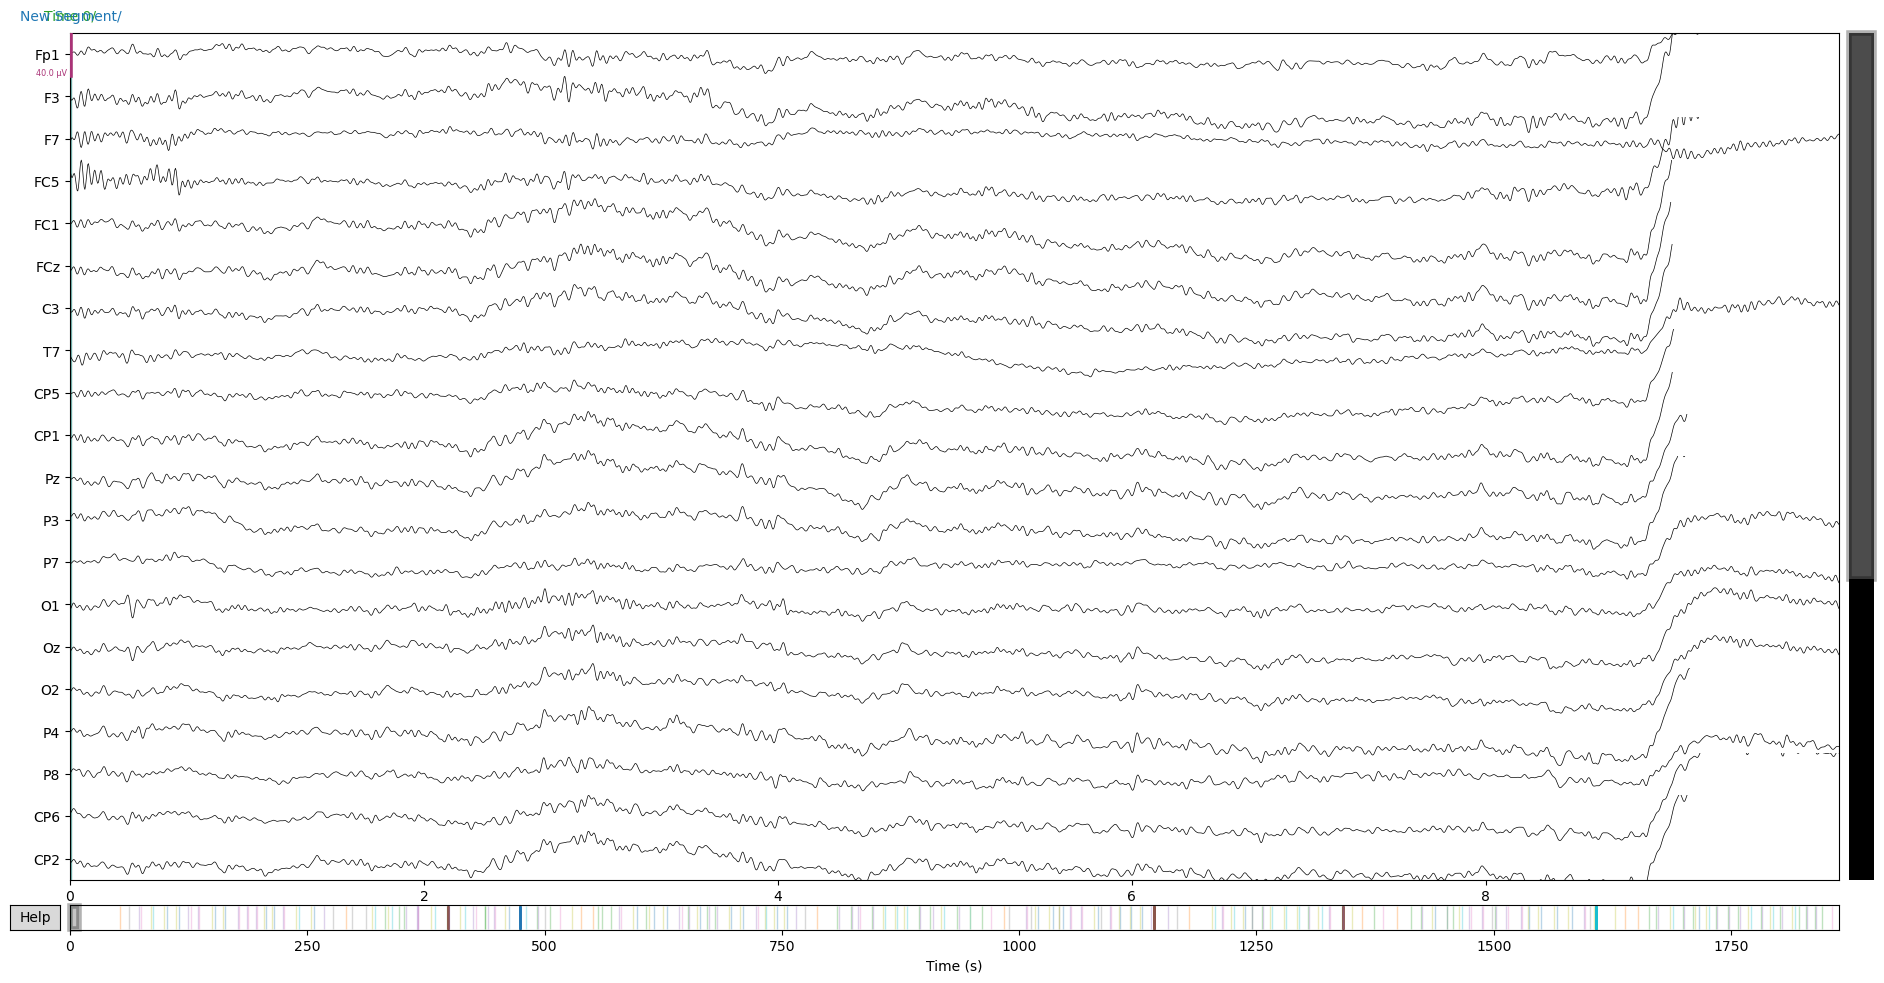

In [2]:
#Load EEG data - preprocessed
import mne
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib qt


#Subject numbers and experiment
sub = "sub-28"
exp = "fixthemix"

fname = f"derivatives/eegprep/{sub}/{sub}_task-{exp}_eegprep.vhdr"
fname = f"../EEG-AutoEnc/eegprep/{sub}/{sub}_task-{exp}_eegprep.vhdr"
raw = mne.io.read_raw_brainvision(fname, preload=True)
events, event_dict = mne.events_from_annotations(raw)
#start of songs in sample numbers
song_starts = np.array(events)[events[:,2] == 10001][2:,0]
press_starts = []
press_starts = events[2:,0]

print(event_dict)
#set sample rate
sample_rate = 250
raw.plot()


In [2]:
#Load FLAC Audio in
import pyflac
import scipy.io.wavfile as wav
import scipy.signal as sig
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

aname = f"derivatives/audio/{sub}/{sub}_task-{exp}_aud.flac"
decoder = pyflac.FileDecoder(aname, "temp.wav")
samp_rate, audio = wav.read("temp.wav")
print(audio.shape)
print(raw.get_data().shape)

#Resample audio to EEG sample rate and get audio envelope
audio = sig.resample(audio, raw.get_data().shape[1])
audio = np.abs(sig.hilbert(audio.T))
audio = np.average(audio, axis=0)
print(audio)
print(np.max(audio), np.min(audio))

# #normalize audio
# scaler = StandardScaler()
# audio = scaler.fit_transform(audio.reshape(-1,1)).reshape(1, -1)
# print(audio)
# print(np.max(audio), np.min(audio))
# print(np.mean(audio), np.std(audio))

audio = np.atleast_2d(audio)

(82188285, 2)
(31, 465923)
[3.89786261 2.16101743 3.89697985 ... 2.16272319 3.89874611 2.16186872]
37195.47015751086 2.014702518637015


In [3]:
#HELPER FUNCTIONS
#================

def split_events(X, Y, events, sample_rate, bound):

    new_X = []
    new_Y = []

    for event in events:
        new_X.append(X[:,event - (sample_rate*bound):event + (sample_rate*bound)])
        new_Y.append(Y[:,event - (sample_rate*bound):event + (sample_rate*bound)])

    return new_X, new_Y



#Build regression matrix
#Adapted from https://stackoverflow.com/questions/5842903/block-tridiagonal-matrix-python 
from scipy.sparse import diags
import numpy as np
fs = 250

#lag_mat takes a given input (stimulus) and generates a time-lagged matrix
#currently set up only for the forward model
def lag_mat(stimulus, sample_rate):

    #sampling frequency
    fs = sample_rate
    #start and end in seconds * frequency = num of samples
    start = int(np.floor(-0.25*fs))
    end = int(np.ceil(0.85*fs))

    #time lag list - sample points for the time lags
    lags = list(range(int(np.floor(-0.25 * fs)), int(np.ceil(0.85 * fs)) + 1))
    n_lags = len(lags)

    #Adapted from https://github.com/powerfulbean/mTRFpy/blob/master/mtrf/matrices.py
    x = np.array([stimulus]).T
    n_samples, n_variables = x.shape
    if max(lags) > n_samples:
        raise ValueError("The maximum lag can't be longer than the signal!")
    lag_matrix = np.zeros((n_samples, n_variables * n_lags))

    for idx, lag in enumerate(lags):
        col_slice = slice(idx * n_variables, (idx + 1) * n_variables)
        if lag < 0:
            lag_matrix[0 : n_samples + lag, col_slice] = x[-lag:, :]
        elif lag > 0:
            lag_matrix[lag:n_samples, col_slice] = x[0 : n_samples - lag, :]
        else:
            lag_matrix[:, col_slice] = x


    return lag_matrix


#generate mask for empty portions of data at end of songs
#stimulus should be given as 1-D
#threshold gives the maximum amplitude of the audio envelope to be considered as
#"no audio"
#minimum gives the number of sample points to be under this threshold for the
#current section of the song to be considered the end
def mask(stimulus, threshold, minimum):
    n_samples = len(stimulus)
    song_mask = np.ones(n_samples)
    min_num = minimum
    thresh = threshold
    zeros = 0
    num=0
    
    for sample in range(n_samples):
        if np.abs(stimulus[sample]) <= thresh:
            zeros += 1
            if zeros == min_num:
                song_mask[sample-min_num-1:n_samples] = np.zeros(n_samples - (sample - min_num-1))
                zeros=0
                num+=1
                break
        else:
            zeros = 0


    return song_mask


from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from scipy.sparse import diags
import random

#split input data into epochs
#give to function as 2d array at the minimum where each column is a sample point
#benchmarks should be a list of sample points
def split(data, benchmarks):
    n_samples = data.shape[-1]
    songs = []
    prev = 0
    for song in benchmarks:
        songs.append(data[:,prev:song])
        prev = song

    return songs

#train the l2 model (from paper)
#lam is the regularization parameter
def train_l2(X, Y, lam, samp_rate):
    n = (X.T@X).shape[0]
    k = [-np.ones(n-1),2*np.ones(n),-np.ones(n-1)]
    offset = [-1,0,1]
    M = diags(k,offset).toarray()

    M[0,0] -= 1
    M[-1, -1] -= 1
    M *= samp_rate

    W = np.linalg.inv(X.T@X + lam*M)@(X.T@Y)*samp_rate
    return W

#perform cross validation on data
#
def cross_validation(X, Y, K=1, method='ridge', alpha=1., ratio=0.5):
    scaler = StandardScaler()
    fs = 250
    assert method in ['ridge', 'l2', 'lasso', 'l1', 'elastic', 'elasticnet']

    if type(alpha) != list:
        alpha = [alpha]
    if type(ratio) != list:
        ratio = [ratio]


    if method in ['ridge', 'l2']:

        results = {f'{a}':None for a in alpha}

        for val in alpha:

            avg = []

            #leave 1 out cross val
            if False:
                pass
                num = K*-1
                #shuffle data
                ind = np.arange(len(X))
                random.shuffle(ind)
                X_shuffled = np.array(X)[ind]
                Y_shuffled = np.array(Y)[ind]
                
                for i in range(len(X)):
                    X_test = X_shuffled[i]
                    X_shuffled
                    


            #regular K-fold cross val    
            else:
                #shuffle data
                ind = np.arange(1,len(X)+1)
                random.shuffle(ind)
                X_shuffled = []
                Y_shuffled = []
                for i in ind:
                    X_shuffled.append(X[f'song{i}'])
                    Y_shuffled.append(Y[f'song{i}'])


                #split data into K roughly even subsets
                length = len(X_shuffled) // K
                for i in range(length):
                    X_test, Y_test, X_train, Y_train = [], [], [], []

                    for j in range(len(X_shuffled)):
                        if j in list(np.arange(i*K, (i+1)*K)):
                            X_test.append(X_shuffled[j])
                            Y_test.append(Y_shuffled[j].T)
                        else:
                            X_train.append(X_shuffled[j])
                            Y_train.append(Y_shuffled[j].T)
                    
                   
                    try:
                        W = 0
                        for j in range(len(X_train)):
                            if type(W) == int:
                                W = train_l2(X_train[j], Y_train[j], val, fs)
                            else:
                                W += train_l2(X_train[j], Y_train[j], val, fs)

                        W = W/len(X_train)

                        W = scaler.fit_transform(W)
                        
                        X_avg = 0
                        Y_avg = 0

                        for j in range(len(X_test)):
                            if type(X_avg) == int:
                                X_avg = X_test[j]
                                Y_avg = Y_test[j]
                            else:
                                X_avg +=  X_test[j]
                                Y_avg += Y_test[j]

                        X_avg = X_avg/len(X_test)
                        Y_avg = Y_avg/len(Y_test)

                        X_avg = scaler.fit_transform(X_avg)
                        Y_avg = scaler.fit_transform(Y_avg)

                        Y_pred = X_avg@W
                        avg.append(mean_squared_error(Y_avg, Y_pred))
                    except Exception as e:
                        print(f"\nError {e} occurred in L2 with alpha = {val}\n")
                        avg.append(np.inf)
                
                results[f'{val}'] = np.mean(avg)

    if method in ['lasso',  'l1']:
        
        results = {f'{a}':None for a in alpha}

        for val in alpha:

            avg = []

            #leave 1 out cross val
            if False:
                pass
                num = K*-1
                #shuffle data
                ind = np.arange(len(X))
                random.shuffle(ind)
                X_shuffled = np.array(X)[ind]
                Y_shuffled = np.array(Y)[ind]
                
                for i in range(len(X)):
                    X_test = X_shuffled[i]
                    X_shuffled
                    


            #regular K-fold cross val    
            else:
                #shuffle data
                ind = np.arange(1,len(X)+1)
                random.shuffle(ind)
                X_shuffled = []
                Y_shuffled = []
                for i in ind:
                    X_shuffled.append(X[f'song{i}'])
                    Y_shuffled.append(Y[f'song{i}'])


                #split data into K roughly even subsets
                length = len(X_shuffled) // K
                for i in range(length):
                    X_test, Y_test, X_train, Y_train = [], [], [], []

                    for j in range(len(X_shuffled)):
                        if j in list(np.arange(i*K, (i+1)*K)):
                            X_test.extend(X_shuffled[j])
                            Y_test.extend(Y_shuffled[j].T)
                        else:
                            X_train.extend(X_shuffled[j])
                            Y_train.extend(Y_shuffled[j].T)
                    
                    X_train = np.array(X_train)
                    X_test = np.array(X_test)
                    Y_train = np.array(Y_train)
                    Y_test = np.array(Y_test)
                    try:
                        model = Lasso(alpha=val)
                        model.fit(X_train, Y_train)
                        Y_pred = model.predict(X_test)
                        avg.append(mean_squared_error(Y_test, Y_pred))
                    except Exception as e:
                        print(f'\nError {e} occurred in L1 with alpha = {val}\n')
                        avg.append(np.inf)
                
                results[f'{val}'] = np.mean(avg)



    if method in ['elastic', 'elasticnet']:

        results = {f'{a}, {b}':None for a in alpha for b in ratio}

        for a in alpha:
            for b in ratio:
                avg = []

                #leave 1 out cross val
                if False:
                    pass
                    num = K*-1
                    #shuffle data
                    ind = np.arange(len(X))
                    random.shuffle(ind)
                    X_shuffled = np.array(X)[ind]
                    Y_shuffled = np.array(Y)[ind]
                    
                    for i in range(len(X)):
                        X_test = X_shuffled[i]
                        X_shuffled
                        


                #regular K-fold cross val    
                else:
                    #shuffle data
                    ind = np.arange(1,len(X)+1)
                    random.shuffle(ind)
                    X_shuffled = []
                    Y_shuffled = []
                    for i in ind:
                        X_shuffled.append(X[f'song{i}'])
                        Y_shuffled.append(Y[f'song{i}'])


                    #split data into K roughly even subsets
                    length = len(X_shuffled) // K
                    for i in range(length):
                        X_test, Y_test, X_train, Y_train = [], [], [], []

                        for j in range(len(X_shuffled)):
                            if j in list(np.arange(i*K, (i+1)*K)):
                                X_test.extend(X_shuffled[j])
                                Y_test.extend(Y_shuffled[j].T)
                            else:
                                X_train.extend(X_shuffled[j])
                                Y_train.extend(Y_shuffled[j].T)
                        
                        X_train = np.array(X_train)
                        X_test = np.array(X_test)
                        Y_train = np.array(Y_train)
                        Y_test = np.array(Y_test)
                        try:
                            model = ElasticNet(alpha=a, l1_ratio=b)
                            model.fit(X_train, Y_train)
                            Y_pred = model.predict(X_test)
                            avg.append(mean_squared_error(Y_test, Y_pred))
                        except Exception as e:
                            print(f'\nError {e} occurred in elasticnet with values alpha={a} and ratio={b}\n')
                    
                    results[f'{a}, {b}'] = np.mean(avg)


    return results

from sklearn.linear_model import Ridge

def train(X, Y, method='ridge', alpha=1., ratio=0.5, sample_rate=250):
    X_train, Y_train = X, Y

    fs = sample_rate
    
    if method in ['custom']:

        W_s = [train_l2(X_train[i], Y_train[i], alpha, fs) for i in range(len(X_train))]
        W = None
        for i in W_s:
            W = (W + i if not(W is None) else i)

        W = W/len(W_s)

    if method in ['ridge',  'l2']:
        model = Ridge(alpha=alpha)

        W_s = []

        for i in range(len(X_train)):
            model.fit(X_train[i], Y_train[i])
            W_s.append(model.coef_.T)

        W = None
        for i in W_s:
            W = (W + i if not(W is None) else i)

        W = W/len(W_s)

    if method in ['lasso',  'l1']:
        model = Lasso(alpha=alpha)

        W_s = []

        for i in range(len(X_train)):
            model.fit(X_train[i], Y_train[i])
            W_s.append(model.coef_.T)

        W = None
        for i in W_s:
            W = (W + i if not(W is None) else i)

        W = W/len(W_s)

    if method in ['elastic', 'elasticnet', 'elastic-net']:
        model = ElasticNet(alpha=alpha, l1_ratio=ratio)

        W_s = []

        for i in range(len(X_train)):
            model.fit(X_train[i], Y_train[i])
            W_s.append(model.coef_.T)

        W = None
        for i in W_s:
            W = (W + i if not(W is None) else i)

        W = W/len(W_s)

    return W


In [4]:
#SPLIT BY SONG

#Split audio and eeg up into their corresponding songs
#note that the 1st elements are the whitespace before the first song starts

split_eeg = scaler.fit_transform(raw.get_data().T).T

split_audio = split(audio, song_starts)
split_eeg = split(split_eeg, song_starts)

fs = sample_rate

labels = [f'song{i}' for i in range(1, len(split_audio))]
labels_train, labels_test = train_test_split(labels, train_size=0.8, test_size=0.2, random_state=5)


print(np.min(split_audio[2]))

#X and Y are dictionaries so that the ordering of the corresponding segments can
#be maintained
X = {}
Y = {}
for i in range(1,len(split_audio)):
    #X gets masked here (remove white space at end of songs)
    print(len(split_audio[i][0]))
    #X[f'song{i}'] = np.atleast_2d(mask(split_audio[i][0], 0.9, 5000)).T * lag_mat(split_audio[i][0], fs)
    X[f'song{i}'] = lag_mat(split_audio[i][0], fs)

    Y[f'song{i}'] = split_eeg[i]

X_test, X_train, Y_test, Y_train = [],[],[],[]

for i in labels_train:
    X_train.append(X[i])
    Y_train.append(scaler.fit_transform(Y[i].T))

for i in labels_test:
    X_test.append(X[i])
    Y_test.append(scaler.fit_transform(Y[i].T))

2.5893768212532198
59010
49021
48761
54833
63586


In [5]:
#hyperparameters
alphas = [10.**x for x in np.arange(5,30)]
alphas = list(np.sort(alphas))
ratios = [x/10 for x in np.arange(1,10, 2)]

custom_res = {}
l1_res = {}
l2_res = {}
elastic_res = {}


for alpha in alphas:

    try:
        custom_res[f'{alpha}'] = train(X_train, Y_train, method = 'custom', alpha = alpha)
    except Exception as e:
        print(f"Exception {e} for alpha = {alpha} in custom")
        custom_res[f'{alpha}'] = None

    try:
        l2_res[f'{alpha}'] = train(X_train, Y_train, method = 'l2', alpha = alpha)
    except Exception as e:
        print(f"Exception {e} for alpha = {alpha} in l2")
        l2_res[f'{alpha}'] = None

    try:
        l1_res[f'{alpha}'] = train(X_train, Y_train, method = 'l1', alpha = alpha)
    except Exception as e:
        print(f"Exception {e} for alpha = {alpha} in l1")
        l1_res[f'{alpha}'] = None

for alpha in alphas:
    for ratio in ratios:
        try:
            elastic_res[f'{alpha}-{ratio}'] = train(X_train, Y_train, method = 'elastic', alpha = alpha, ratio=ratio)
        except Exception as e:
            print(f"Exception {e} for alpha = {alpha} in elasticnet")
            elastic_res[f'{alpha}'] = None

results = {'L1':{}, 'L2':{}, 'Elasticnet':{}, 'Custom':{}}


best_custom = None
best_custom_score = np.inf

print("Custom Results:\n")
for result in custom_res:
    if not (custom_res[result] is None):
        recon = None
        for i in range(len(X_test)):
            recon = (recon + mean_squared_error(Y_test[i], X_test[i]@custom_res[result]) if not( recon is None ) else mean_squared_error(Y_test[i], X_test[i]@custom_res[result]))

        recon = recon/len(X_test)
        results['Custom'][result] = recon

        print(f'alpha = {result}: MSE = {recon}')

        if best_custom is None:
            best_custom = result
            best_custom_score = recon

        else:
            if best_custom_score > recon:
                best_custom_score = recon
                best_custom = result

    else:
        results['Custom'][result] = np.nan


best_l2 = None
best_l2_score = np.inf

print("L2 Results:\n")
for result in l2_res:
    if not (l2_res[result] is None):
        recon = None
        for i in range(len(X_test)):
            recon = (recon + mean_squared_error(Y_test[i], X_test[i]@l2_res[result]) if not( recon is None ) else mean_squared_error(Y_test[i], X_test[i]@l2_res[result]))

        recon = recon/len(X_test)
        results['L2'][result] = recon

        print(f'alpha = {result}: MSE = {recon}')

        if best_l2 is None:
            best_l2 = result
            best_l2_score = recon

        else:
            if best_l2_score > recon:
                best_l2_score = recon
                best_l2 = result

    else:
        results['L2'][result] = np.nan

best_l1 = None
best_l1_score = np.inf

print("\nL1 Results:\n")
for result in l1_res:
    if not (l1_res[result] is None):
        recon = None
        for i in range(len(X_test)):
            recon = (recon + mean_squared_error(Y_test[i], X_test[i]@l1_res[result]) if not( recon is None ) else mean_squared_error(Y_test[i], X_test[i]@l1_res[result]))

        recon = recon/len(X_test)
        results['L1'][result] = recon


        print(f'alpha = {result}: MSE = {recon}')

        if best_l1 is None:
            best_l1 = result
            best_l1_score = recon

        else:
            if best_l1_score > recon:
                best_l1_score = recon
                best_l1 = result

    else:
        results['L1'][result] = np.nan

best_elastic = None
best_elastic_score = np.inf

# print("\nElastic Results:\n")
# for result in elastic_res:
#     if not (elastic_res[result] is None):
#         recon = None
#         for i in range(len(X_test)):
#             recon = (recon + mean_squared_error(Y_test[i], X_test[i]@elastic_res[result]) if not( recon is None ) else mean_squared_error(Y_test[i], X_test[i]@elastic_res[result]))

#         recon = recon/len(X_test)
#         results['Elasticnet'][result] = recon


#         print(f'params = {result}: MSE = {recon}')

#         if best_elastic is None:
#             best_elastic = result
#             best_elastic_score = recon

#         else:
#             if best_elastic_score > recon:
#                 best_elastic_score = recon
#                 best_elastic = result

#     else:
#         results['Elasticnet'][result] = np.nan


print(f'Best Custom param: {best_custom} with score {best_custom_score}')
print(f'Best L2 param: {best_l2} with score {best_l2_score}')
print(f'Best L1 param: {best_l1} with score {best_l1_score}')
# print(f'Best elastic param: {best_elastic} with score {best_elastic_score}')

plt.figure()

xs = np.log10(alphas)
series1 = np.array(list(results['Custom'].values()))
series2 = np.array(list(results['L1'].values()))
series3 = np.array(list(results['L2'].values()))

mask1 = np.isfinite(series1)
mask2 = np.isfinite(series2)
mask3 = np.isfinite(series3)

plt.plot(xs[mask1], series1[mask1], color='g', label="Quadratic")
plt.plot(xs[mask2], series2[mask2], color='b', label="L1")
plt.plot(xs[mask3], series3[mask3], color='r', label="L2")
plt.xlabel('Regularization Value (Exponent)')
plt.ylabel('MSE')
plt.legend()
plt.title('L1, L2, and Quadratic Regularization MSE Scores (Songs)')
plt.show()

# plt.figure()
# plt.plot(list(results['Elasticnet'].keys()), list(results['Elasticnet'].values()), '.')
# plt.xlabel("Parameters (Regularization Constant-L1 Ratio)")
# plt.ylabel("MSE")
# plt.title('Elasticnet Regularization MSE Scores')
# plt.show()


Exception Singular matrix for alpha = 1e+28 in custom
Exception Singular matrix for alpha = 1e+29 in custom
Custom Results:

alpha = 100000.0: MSE = 88.23268481390177
alpha = 1000000.0: MSE = 88.1653888452273
alpha = 10000000.0: MSE = 87.90322213489125
alpha = 100000000.0: MSE = 86.46731511035654
alpha = 1000000000.0: MSE = 78.88471091240343
alpha = 10000000000.0: MSE = 61.18337888548214
alpha = 100000000000.0: MSE = 46.903619455878484
alpha = 1000000000000.0: MSE = 38.556275807683306
alpha = 10000000000000.0: MSE = 29.991845199296737
alpha = 100000000000000.0: MSE = 18.51889742129841
alpha = 1000000000000000.0: MSE = 16.04657514335881
alpha = 1e+16: MSE = 15.843239337975753
alpha = 1e+17: MSE = 15.842603634697685
alpha = 1e+18: MSE = 15.843068242288684
alpha = 1e+19: MSE = 15.84312069511037
alpha = 1e+20: MSE = 15.84312325966959
alpha = 1e+21: MSE = 15.843125745282238
alpha = 1e+22: MSE = 15.843047766258172
alpha = 1.0000000000000001e+23: MSE = 15.843501604507571
alpha = 1e+24: MSE = 

In [6]:
from matplotlib import pyplot as plt
scaler = StandardScaler()

ind = 0

valW = scaler.fit_transform(custom_res[best_custom])

recon = []

for i in range(len(X_test)):
    recon.append(scaler.fit_transform(X_test[i]@valW))

print(recon)
print(len(recon))

fig, axs = plt.subplots(4, 8)
plt.suptitle("All Channels of TRF (Averaged Over Each Song in Test Set)")
for i in range(4):
    for j in range(8):
        try:
            axs[i, j].plot(np.linspace(-0.25, 0.85, valW.shape[0]), valW[:,(i*8) + j])
            #axs[i, j].plot(np.linspace(-0.25, 0.85, model.coef_.shape[0]), model.coef_[:,(i*8) + j])

        except Exception as e:
            axs[i, j].plot(np.linspace(-0.25,0.85, valW.shape[0]), valW)
            print(f"{e}")


fig, axs = plt.subplots(4, 8)
plt.suptitle(f"All Channels of Reconstructed EEG Data Compared with Actual EEG Data")

for i in range(4):
    for j in range(8):
        try:
            axs[i, j].plot(recon[ind][:,(i*8) + j],  color='blue')
            #axs[i, j].plot(models[0].predict(X['song3'])[:,(i*8) + j])

            axs[i,j].plot(Y_test[ind].T[(i*8) + j], alpha=0.5, color='red')

        except Exception as e:
            print(e)
            dummy0=axs[i, j].plot(recon[ind][:,0], label = "Reconstructed", color="blue")
            dummy1=axs[i, j].plot(recon[ind][:,0], label="Actual", color='red')

            fig.legend([dummy0, dummy1], labels=["Reconstructed", "Actual"], loc='upper right')

            for a in dummy0:
                a.set_visible(False)

            for a in dummy1:
                a.set_visible(False)

            # axs[i,j].title.set_text("All Channels Of Reconstructed Data")


plt.show()

[array([[ 0.0165403 ,  0.01973611,  0.00970279, ...,  0.0183209 ,
         0.01300594,  0.02086175],
       [ 0.01658135,  0.01972791,  0.00984719, ...,  0.0183296 ,
         0.01309058,  0.02083784],
       [ 0.01684131,  0.01999628,  0.01008715, ...,  0.01859066,
         0.0133336 ,  0.02110997],
       ...,
       [-0.0046927 , -0.00553786, -0.00288489, ..., -0.00515598,
        -0.00374457, -0.00584064],
       [-0.00481902, -0.00565923, -0.00301439, ..., -0.00528149,
        -0.003872  , -0.00596055],
       [-0.00483857, -0.00568529, -0.00302633, ..., -0.00530054,
        -0.00388424, -0.00598928]])]
1
index 31 is out of bounds for axis 1 with size 31
index 31 is out of bounds for axis 1 with size 31


C:\Users\malco\AppData\Local\Temp\ipykernel_44348\1951856655.py:45: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend([dummy0, dummy1], labels=["Reconstructed", "Actual"], loc='upper right')


In [7]:
#SPLIT BY SEGMENT

#Split audio and eeg up into their corresponding songs
#note that the 1st elements are the whitespace before the first song starts

split_eeg = raw.get_data()
times = np.linspace(song_starts[1], raw.get_data().shape[1], 300, dtype = int)
split_audio, split_eeg = split_events(audio, split_eeg, times, 250, 5)

fs = sample_rate

labels = [f'song{i}' for i in range(1, len(split_audio))]
labels_train, labels_test = train_test_split(labels, train_size=0.8, test_size=0.2, random_state=5)


#X and Y are dictionaries so that the ordering of the corresponding segments can
#be maintained
X = {}
Y = {}
for i in range(1,len(split_audio)):
    #X gets masked here (remove white space at end of songs)
    X[f'song{i}'] = lag_mat(split_audio[i][0], fs)
    #X[f'song{i}'] = lag_mat(split_audio[i][0], fs)

    Y[f'song{i}'] = split_eeg[i]

X_test, X_train, Y_test, Y_train = [],[],[],[]

for i in labels_train:
    X_train.append(X[i])
    Y_train.append(scaler.fit_transform(Y[i].T))

for i in labels_test:
    X_test.append(X[i])
    Y_test.append(scaler.fit_transform(Y[i].T))

In [8]:
#hyperparameters
alphas = [10.**x for x in np.arange(5,30)]
alphas = list(np.sort(alphas))
ratios = [x/10 for x in np.arange(1,10, 2)]

custom_res = {}
l1_res = {}
l2_res = {}
elastic_res = {}


for alpha in alphas:

    try:
        custom_res[f'{alpha}'] = train(X_train, Y_train, method = 'custom', alpha = alpha)
    except Exception as e:
        print(f"Exception {e} for alpha = {alpha} in custom")
        custom_res[f'{alpha}'] = None

    try:
        l2_res[f'{alpha}'] = train(X_train, Y_train, method = 'l2', alpha = alpha)
    except Exception as e:
        print(f"Exception {e} for alpha = {alpha} in l2")
        l2_res[f'{alpha}'] = None

    try:
        l1_res[f'{alpha}'] = train(X_train, Y_train, method = 'l1', alpha = alpha)
    except Exception as e:
        print(f"Exception {e} for alpha = {alpha} in l1")
        l1_res[f'{alpha}'] = None

print("ELASTIC")
# for alpha in alphas:
#     for ratio in ratios:
#         try:
#             elastic_res[f'{alpha}-{ratio}'] = train(X_train, Y_train, method = 'elastic', alpha = alpha, ratio=ratio)
#         except Exception as e:
#             print(f"Exception {e} for alpha = {alpha} in elasticnet")
#             elastic_res[f'{alpha}'] = None

results = {'L1':{}, 'L2':{}, 'Elasticnet':{}, 'Custom':{}}


best_custom = None
best_custom_score = np.inf

print("Custom Results:\n")
for result in custom_res:
    if not (custom_res[result] is None):
        recon = None
        for i in range(len(X_test)):
            recon = (recon + mean_squared_error(Y_test[i], X_test[i]@custom_res[result]) if not( recon is None ) else mean_squared_error(Y_test[i], X_test[i]@custom_res[result]))

        recon = recon/len(X_test)
        results['Custom'][result] = recon

        print(f'alpha = {result}: MSE = {recon}')

        if best_custom is None:
            best_custom = result
            best_custom_score = recon

        else:
            if best_custom_score > recon:
                best_custom_score = recon
                best_custom = result

    else:
        results['Custom'][result] = np.nan


best_l2 = None
best_l2_score = np.inf

print("L2 Results:\n")
for result in l2_res:
    if not (l2_res[result] is None):
        recon = None
        for i in range(len(X_test)):
            recon = (recon + mean_squared_error(Y_test[i], X_test[i]@l2_res[result]) if not( recon is None ) else mean_squared_error(Y_test[i], X_test[i]@l2_res[result]))

        recon = recon/len(X_test)
        results['L2'][result] = recon

        print(f'alpha = {result}: MSE = {recon}')

        if best_l2 is None:
            best_l2 = result
            best_l2_score = recon

        else:
            if best_l2_score > recon:
                best_l2_score = recon
                best_l2 = result

    else:
        results['L2'][result] = np.nan

best_l1 = None
best_l1_score = np.inf

print("\nL1 Results:\n")
for result in l1_res:
    if not (l1_res[result] is None):
        recon = None
        for i in range(len(X_test)):
            recon = (recon + mean_squared_error(Y_test[i], X_test[i]@l1_res[result]) if not( recon is None ) else mean_squared_error(Y_test[i], X_test[i]@l1_res[result]))

        recon = recon/len(X_test)
        results['L1'][result] = recon


        print(f'alpha = {result}: MSE = {recon}')

        if best_l1 is None:
            best_l1 = result
            best_l1_score = recon

        else:
            if best_l1_score > recon:
                best_l1_score = recon
                best_l1 = result

    else:
        results['L1'][result] = np.nan

best_elastic = None
# best_elastic_score = np.inf

# print("\nElastic Results:\n")
# for result in elastic_res:
#     if not (elastic_res[result] is None):
#         recon = None
#         for i in range(len(X_test)):
#             recon = (recon + mean_squared_error(Y_test[i], X_test[i]@elastic_res[result]) if not( recon is None ) else mean_squared_error(Y_test[i], X_test[i]@elastic_res[result]))

#         recon = recon/len(X_test)
#         results['Elasticnet'][result] = recon


#         print(f'params = {result}: MSE = {recon}')

#         if best_elastic is None:
#             best_elastic = result
#             best_elastic_score = recon

#         else:
#             if best_elastic_score > recon:
#                 best_elastic_score = recon
#                 best_elastic = result

#     else:
#         results['Elasticnet'][result] = np.nan


print(f'Best Custom param: {best_custom} with score {best_custom_score}')
print(f'Best L2 param: {best_l2} with score {best_l2_score}')
print(f'Best L1 param: {best_l1} with score {best_l1_score}')
# print(f'Best elastic param: {best_elastic} with score {best_elastic_score}')

plt.figure()

xs = np.log10(alphas)
series1 = np.array(list(results['Custom'].values()))
series2 = np.array(list(results['L1'].values()))
series3 = np.array(list(results['L2'].values()))

mask1 = np.isfinite(series1)
mask2 = np.isfinite(series2)
mask3 = np.isfinite(series3)

plt.plot(xs[mask1], series1[mask1], color='g', label="Quadratic")
plt.plot(xs[mask2], series2[mask2], color='b', label="L1")
plt.plot(xs[mask3], series3[mask3], color='r', label="L2")
plt.xlabel('Regularization Value (Exponent)')
plt.ylabel('MSE')
plt.legend()
plt.title('L1, L2, and Quadratic Regularization MSE Scores (Segments)')
plt.show()

# plt.figure()
# plt.plot(list(results['Elasticnet'].keys()), list(results['Elasticnet'].values()), '.')
# plt.xlabel("Parameters (Regularization Constant-L1 Ratio)")
# plt.ylabel("MSE")
# plt.title('Elasticnet Regularization MSE Scores')
# plt.show()


Exception Singular matrix for alpha = 1e+21 in custom
Exception Singular matrix for alpha = 1e+22 in custom
Exception Singular matrix for alpha = 1e+24 in custom
Exception Singular matrix for alpha = 1e+25 in custom
Exception Singular matrix for alpha = 1e+26 in custom
Exception Singular matrix for alpha = 1e+28 in custom
Exception Singular matrix for alpha = 1e+29 in custom
ELASTIC
Custom Results:

alpha = 100000.0: MSE = 627227.1012243597
alpha = 1000000.0: MSE = 249671.9130058792
alpha = 10000000.0: MSE = 133958.62552287147
alpha = 100000000.0: MSE = 44302.3287912053
alpha = 1000000000.0: MSE = 13414.634209086887
alpha = 10000000000.0: MSE = 12164.00936773327
alpha = 100000000000.0: MSE = 12051.606603858203
alpha = 1000000000000.0: MSE = 11935.76400982187
alpha = 10000000000000.0: MSE = 11870.22296449007
alpha = 100000000000000.0: MSE = 11837.178521231946
alpha = 1000000000000000.0: MSE = 11831.3214873692
alpha = 1e+16: MSE = 11830.665879151931
alpha = 1e+17: MSE = 11829.43104389577

In [9]:
from matplotlib import pyplot as plt
scaler = StandardScaler()

ind = 0

valW = scaler.fit_transform(custom_res[best_custom])

recon = []

for i in range(len(X_test)):
    recon.append(scaler.fit_transform(X_test[i]@valW))

fig, axs = plt.subplots(4, 8)
plt.suptitle("All Channels of TRF (Averaged Over Each Segment in Test Set)")
for i in range(4):
    for j in range(8):
        try:
            axs[i, j].plot(np.linspace(-0.25, 0.85, valW.shape[0]), valW[:,(i*8) + j])
            #axs[i, j].plot(np.linspace(-0.25, 0.85, model.coef_.shape[0]), model.coef_[:,(i*8) + j])

        except Exception as e:
            axs[i, j].plot(np.linspace(-0.25,0.85, valW.shape[0]), valW)
            print(f"{e}")


fig, axs = plt.subplots(4, 8)
plt.suptitle(f"All Channels of Reconstructed EEG Data Compared with Actual EEG Data")

for i in range(4):
    for j in range(8):
        try:
            axs[i, j].plot(recon[ind][:,(i*8) + j],  color='blue')
            #axs[i, j].plot(models[0].predict(X['song3'])[:,(i*8) + j])

            axs[i,j].plot(Y_test[ind].T[(i*8) + j], alpha=0.5, color='red')

        except Exception as e:
            print(e)
            dummy0=axs[i, j].plot(recon[ind][:,0], label = "Reconstructed", color="blue")
            dummy1=axs[i, j].plot(recon[ind][:,0], label="Actual", color='red')

            fig.legend([dummy0, dummy1], labels=["Reconstructed", "Actual"], loc='upper right')

            for a in dummy0:
                a.set_visible(False)

            for a in dummy1:
                a.set_visible(False)

            # axs[i,j].title.set_text("All Channels Of Reconstructed Data")



index 31 is out of bounds for axis 1 with size 31
index 31 is out of bounds for axis 1 with size 31


C:\Users\malco\AppData\Local\Temp\ipykernel_44348\141820214.py:42: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend([dummy0, dummy1], labels=["Reconstructed", "Actual"], loc='upper right')


In [10]:
from matplotlib import pyplot as plt

#SPLIT BY EVENT

#Split audio and eeg up into their corresponding songs
#note that the 1st elements are the whitespace before the first song starts

split_eeg = raw.get_data()

split_audio, split_eeg = split_events(np.atleast_2d(audio), np.atleast_2d(split_eeg), press_starts, 250, 5)
fs = sample_rate

labels = [f'song{i}' for i in range(1, len(split_audio))]
labels_train, labels_test = train_test_split(labels, train_size=0.8, test_size=0.2, random_state=5)


#X and Y are dictionaries so that the ordering of the corresponding segments can
#be maintained
X = {}
Y = {}
for i in range(1,len(split_audio)):
    X[f'song{i}'] = lag_mat(split_audio[i][0], fs)
    Y[f'song{i}'] = split_eeg[i]

X_test, X_train, Y_test, Y_train = [],[],[],[]

for i in labels_train:
    X_train.append(X[i])
    Y_train.append(scaler.fit_transform(Y[i].T))

for i in labels_test:
    X_test.append(X[i])
    Y_test.append(scaler.fit_transform(Y[i].T))


In [11]:
#hyperparameters
alphas = [10.**x for x in np.arange(5,30)]
alphas = list(np.sort(alphas))
ratios = [x/10 for x in np.arange(1,10, 2)]

custom_res = {}
l1_res = {}
l2_res = {}
elastic_res = {}


for alpha in alphas:

    try:
        custom_res[f'{alpha}'] = train(X_train, Y_train, method = 'custom', alpha = alpha)
    except Exception as e:
        print(f"Exception {e} for alpha = {alpha} in custom")
        custom_res[f'{alpha}'] = None

    try:
        l2_res[f'{alpha}'] = train(X_train, Y_train, method = 'l2', alpha = alpha)
    except Exception as e:
        print(f"Exception {e} for alpha = {alpha} in l2")
        l2_res[f'{alpha}'] = None

    try:
        l1_res[f'{alpha}'] = train(X_train, Y_train, method = 'l1', alpha = alpha)
    except Exception as e:
        print(f"Exception {e} for alpha = {alpha} in l1")
        l1_res[f'{alpha}'] = None

# for alpha in alphas:
#     for ratio in ratios:
#         try:
#             elastic_res[f'{alpha}-{ratio}'] = train(X_train, Y_train, method = 'elastic', alpha = alpha, ratio=ratio)
#         except Exception as e:
#             print(f"Exception {e} for alpha = {alpha} in elasticnet")
#             elastic_res[f'{alpha}'] = None

results = {'L1':{}, 'L2':{}, 'Elasticnet':{}, 'Custom':{}}


best_custom = None
best_custom_score = np.inf

print("Custom Results:\n")
for result in custom_res:
    if not (custom_res[result] is None):
        recon = None
        for i in range(len(X_test)):
            recon = (recon + mean_squared_error(Y_test[i], X_test[i]@custom_res[result]) if not( recon is None ) else mean_squared_error(Y_test[i], X_test[i]@custom_res[result]))

        recon = recon/len(X_test)
        results['Custom'][result] = recon

        print(f'alpha = {result}: MSE = {recon}')

        if best_custom is None:
            best_custom = result
            best_custom_score = recon

        else:
            if best_custom_score > recon:
                best_custom_score = recon
                best_custom = result

    else:
        results['Custom'][result] = np.nan


best_l2 = None
best_l2_score = np.inf

print("L2 Results:\n")
for result in l2_res:
    if not (l2_res[result] is None):
        recon = None
        for i in range(len(X_test)):
            recon = (recon + mean_squared_error(Y_test[i], X_test[i]@l2_res[result]) if not( recon is None ) else mean_squared_error(Y_test[i], X_test[i]@l2_res[result]))

        recon = recon/len(X_test)
        results['L2'][result] = recon

        print(f'alpha = {result}: MSE = {recon}')

        if best_l2 is None:
            best_l2 = result
            best_l2_score = recon

        else:
            if best_l2_score > recon:
                best_l2_score = recon
                best_l2 = result

    else:
        results['L2'][result] = np.nan

best_l1 = None
best_l1_score = np.inf

print("\nL1 Results:\n")
for result in l1_res:
    if not (l1_res[result] is None):
        recon = None
        for i in range(len(X_test)):
            recon = (recon + mean_squared_error(Y_test[i], X_test[i]@l1_res[result]) if not( recon is None ) else mean_squared_error(Y_test[i], X_test[i]@l1_res[result]))

        recon = recon/len(X_test)
        results['L1'][result] = recon


        print(f'alpha = {result}: MSE = {recon}')

        if best_l1 is None:
            best_l1 = result
            best_l1_score = recon

        else:
            if best_l1_score > recon:
                best_l1_score = recon
                best_l1 = result

    else:
        results['L1'][result] = np.nan

best_elastic = None
best_elastic_score = np.inf

# print("\nElastic Results:\n")
# for result in elastic_res:
#     if not (elastic_res[result] is None):
#         recon = None
#         for i in range(len(X_test)):
#             recon = (recon + mean_squared_error(Y_test[i], X_test[i]@elastic_res[result]) if not( recon is None ) else mean_squared_error(Y_test[i], X_test[i]@elastic_res[result]))

#         recon = recon/len(X_test)
#         results['Elasticnet'][result] = recon


#         print(f'params = {result}: MSE = {recon}')

#         if best_elastic is None:
#             best_elastic = result
#             best_elastic_score = recon

#         else:
#             if best_elastic_score > recon:
#                 best_elastic_score = recon
#                 best_elastic = result

#     else:
#         results['Elasticnet'][result] = np.nan


print(f'Best Custom param: {best_custom} with score {best_custom_score}')
print(f'Best L2 param: {best_l2} with score {best_l2_score}')
print(f'Best L1 param: {best_l1} with score {best_l1_score}')
#print(f'Best elastic param: {best_elastic} with score {best_elastic_score}')

plt.figure()

xs = np.log10(alphas)
series1 = np.array(list(results['Custom'].values()))
series2 = np.array(list(results['L1'].values()))
series3 = np.array(list(results['L2'].values()))

mask1 = np.isfinite(series1)
mask2 = np.isfinite(series2)
mask3 = np.isfinite(series3)

plt.plot(xs[mask1], series1[mask1], color='g', label="Quadratic")
plt.plot(xs[mask2], series2[mask2], color='b', label="L1")
plt.plot(xs[mask3], series3[mask3], color='r', label="L2")
plt.xlabel('Regularization Value (Exponent)')
plt.ylabel('MSE')
plt.legend()
plt.title('L1, L2, and Quadratic Regularization MSE Scores (Events)')
plt.show()

# plt.figure()
# plt.plot(list(results['Elasticnet'].keys()), list(results['Elasticnet'].values()), '.')
# plt.xlabel("Parameters (Regularization Constant-L1 Ratio)")
# plt.ylabel("MSE")
# plt.title('Elasticnet Regularization MSE Scores')
# plt.show()


Exception Singular matrix for alpha = 1e+21 in custom
Exception Singular matrix for alpha = 1e+22 in custom
Exception Singular matrix for alpha = 1e+24 in custom
Exception Singular matrix for alpha = 1e+25 in custom
Exception Singular matrix for alpha = 1e+26 in custom
Exception Singular matrix for alpha = 1e+28 in custom
Exception Singular matrix for alpha = 1e+29 in custom
Custom Results:

alpha = 100000.0: MSE = 194732.71058946548
alpha = 1000000.0: MSE = 85491.64907918812
alpha = 10000000.0: MSE = 29785.361538046564
alpha = 100000000.0: MSE = 11710.703103343665
alpha = 1000000000.0: MSE = 5815.048225382482
alpha = 10000000000.0: MSE = 4121.656895005183
alpha = 100000000000.0: MSE = 3583.7199018658657
alpha = 1000000000000.0: MSE = 3103.6946794508794
alpha = 10000000000000.0: MSE = 2822.8906074224487
alpha = 100000000000000.0: MSE = 2808.8147225870007
alpha = 1000000000000000.0: MSE = 2809.6345756300097
alpha = 1e+16: MSE = 2809.755719491279
alpha = 1e+17: MSE = 2809.8022501180835
a

In [12]:
from matplotlib import pyplot as plt
scaler = StandardScaler()

ind = 0

valW = scaler.fit_transform(custom_res[best_custom])

recon = []

for i in range(len(X_test)):
    recon.append(scaler.fit_transform(X_test[i]@valW))

fig, axs = plt.subplots(4, 8)
plt.suptitle("All Channels of TRF (Averaged Over Each Event in Test Set)")
for i in range(4):
    for j in range(8):
        try:
            axs[i, j].plot(np.linspace(-0.25, 0.85, valW.shape[0]), valW[:,(i*8) + j])
            #axs[i, j].plot(np.linspace(-0.25, 0.85, model.coef_.shape[0]), model.coef_[:,(i*8) + j])

        except Exception as e:
            axs[i, j].plot(np.linspace(-0.25,0.85, valW.shape[0]), valW)
            print(f"{e}")


fig, axs = plt.subplots(4, 8)
plt.suptitle(f"All Channels of Reconstructed EEG Data Compared with Actual EEG Data")

for i in range(4):
    for j in range(8):
        try:
            axs[i, j].plot(recon[ind][:,(i*8) + j],  color='blue')
            #axs[i, j].plot(models[0].predict(X['song3'])[:,(i*8) + j])

            axs[i,j].plot(Y_test[ind].T[(i*8) + j], alpha=0.5, color='red')

        except Exception as e:
            print(e)
            dummy0=axs[i, j].plot(recon[ind][:,0], label = "Reconstructed", color="blue")
            dummy1=axs[i, j].plot(recon[ind][:,0], label="Actual", color='red')

            fig.legend([dummy0, dummy1], labels=["Reconstructed", "Actual"], loc='upper right')

            for a in dummy0:
                a.set_visible(False)

            for a in dummy1:
                a.set_visible(False)

            # axs[i,j].title.set_text("All Channels Of Reconstructed Data")


index 31 is out of bounds for axis 1 with size 31
index 31 is out of bounds for axis 1 with size 31


C:\Users\malco\AppData\Local\Temp\ipykernel_44348\1101253276.py:42: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend([dummy0, dummy1], labels=["Reconstructed", "Actual"], loc='upper right')
